# ЧТО делаем #
Анализируем результаты A/B-теста, чтобы принять обоснованное решение о смене маркетинговой механики.

Было проведено A/B-тестирование в городах присутствия ритейлера в России. Контрольной группе по-прежнему присылали уведомления в форме баннера, а тестовой — в форме пуш-уведомления.

Эксперимент продолжался 3 месяца.

Сплит-система: клиенты разбиты на две группы одинакового размера случайным образом.
Были исследованы две таргет-метрики: конверсия из рекламы в покупку и средний чек покупки.
Выводы оформлены в форме удобного Excel-калькулятора.

### Подготовка ###

In [3]:
### Импорт библиотек и данных

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind

In [4]:

new_dipl_ds = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = None)
data = new_dipl_ds['Данные']
clients = new_dipl_ds['Clients']
regions = new_dipl_ds['Region_dict']

In [5]:
### Проверка, очистка и подготовка данных

regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_trading_point  66 non-null     int64 
 1   city              66 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [6]:

regions.duplicated().sum()

np.int64(0)

In [7]:

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [8]:

clients.duplicated().sum()

np.int64(0)

In [9]:

clients.head()

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [10]:
### отсортируем по возрастанию id_client, сбросим старые индексы и внесем новые в отсортированном по возрастанию порядке

clients.sort_values('id_client', inplace = True)
clients.reset_index(inplace = True)
clients.drop('index', axis = 1, inplace = True)
clients.head(94)

,id_client,dtime_ad,nflag_test,id_trading_point
0,178561,2022-06-03 02:47:49.183,0,453
1,178562,2022-06-03 02:51:21.878,0,2652
2,178563,2022-06-03 02:52:10.616,1,112
3,178564,2022-06-03 02:53:10.089,1,26
4,178565,2022-06-03 02:55:13.525,1,739
...,...,...,...,...
89,178650,2022-06-03 07:46:47.754,0,800
90,178651,2022-06-03 07:51:56.232,0,2652
91,178652,2022-06-03 07:52:06.041,1,1287
92,178653,NaT,1,13


In [11]:
### Отсортировав обнаружили, что рекламные объявляния показывались последовательно по нарастанию порядкового номера id_client
### чтобы сохранить данные для тестирования, заполнили "нулы" в колонке dtime_ad предыдущими по порядку значениями.

clients['dtime_ad'] = clients['dtime_ad'].ffill()
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55605 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [12]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37989 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     37989 non-null  int64         
 1   id_client    37401 non-null  float64       
 2   amt_payment  35845 non-null  float64       
 3   dtime_pay    35560 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.2 MB


In [13]:

data.duplicated().sum()

np.int64(0)

In [14]:

data.isnull().sum()

id_order          0
id_client       588
amt_payment    2144
dtime_pay      2429
dtype: int64

In [15]:
### удалим "нулы" во всем датафрейме

data = data[~data['dtime_pay'].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35560 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     35560 non-null  int64         
 1   id_client    35560 non-null  float64       
 2   amt_payment  35560 non-null  float64       
 3   dtime_pay    35560 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.4 MB


In [16]:

print()
print('Датафрейм regions не содержит "нулов" и дубликатов, форматы данных соответствуют необходимым')
print()
regions.head()


Датафрейм regions не содержит "нулов" и дубликатов, форматы данных соответствуют необходимым



,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


- id_trading_point — уникальный идентификатор торговой точки, к которой прикреплен данный пользователь.
- city — название города.

In [17]:

print()
print(f'Датафрейм clients не содержит дубликатов, форматы данных соответствуют необходимым. Отсортировав датарейм по возрастанию id_client обнаружили, что рекламные объявляния показывались последовательно по нарастанию порядкового номера id_client, соответственно, чтобы не удалять, а сохранить данные для тестирования, заполнили "нулы" в колонке dtime_ad предыдущими по порядку значениями.')
print()
clients.head()


Датафрейм clients не содержит дубликатов, форматы данных соответствуют необходимым. Отсортировав датарейм по возрастанию id_client обнаружили, что рекламные объявляния показывались последовательно по нарастанию порядкового номера id_client, соответственно, чтобы не удалять, а сохранить данные для тестирования, заполнили "нулы" в колонке dtime_ad предыдущими по порядку значениями.



,id_client,dtime_ad,nflag_test,id_trading_point
0,178561,2022-06-03 02:47:49.183,0,453
1,178562,2022-06-03 02:51:21.878,0,2652
2,178563,2022-06-03 02:52:10.616,1,112
3,178564,2022-06-03 02:53:10.089,1,26
4,178565,2022-06-03 02:55:13.525,1,739


- id_client — уникальный идентификатор клиента.
- dtime_ad — дата и время показа рекламного объявления (или баннером в приложении, или пуш-уведомлением, в зависимости от группы).
- nflag_test — группа эксперимента (0 — контроль, 1 — тест).
- id_trading_point — идентификатор торговой точки, к которой прикреплен данный пользователь.

In [18]:

print()
print('Датафрейм regions не содержит "нулов" и дубликатов, форматы данных соответствуют необходимым. Сортировка по dtime_pay, id_client и id_order не показала возможности заполнить пропущенные значения в данных.')
print()
data.head()


Датафрейм regions не содержит "нулов" и дубликатов, форматы данных соответствуют необходимым. Сортировка по dtime_pay, id_client и id_order не показала возможности заполнить пропущенные значения в данных.



,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468


- id_order — уникальный идентификатор покупки.
- id_client — уникальный идентификатор клиента.
- amt_payment — размер платежа.
- dtime_pay — дата и время оплаты.

### Решение ###

In [19]:
### Выведем кол-во торговых точек по городам, визуализируем

tr_p_city = regions.groupby('city').agg(cnt_tr_p = ('id_trading_point', 'count')).sort_values('cnt_tr_p', ascending = False).reset_index()
print('Кол-во городов присутствия ритейлера SkyLenta', regions['city'].nunique())
print()
tr_p_city.head(25)

Кол-во городов присутствия ритейлера SkyLenta 23



,city,cnt_tr_p
0,Санкт-Петербург,11
1,Москва,11
2,Казань,6
3,Новосибирск,6
4,Красноярск,5
5,Краснодар,4
6,Самара,4
7,Мурманск,2
8,Сочи,2
9,Саратов,2


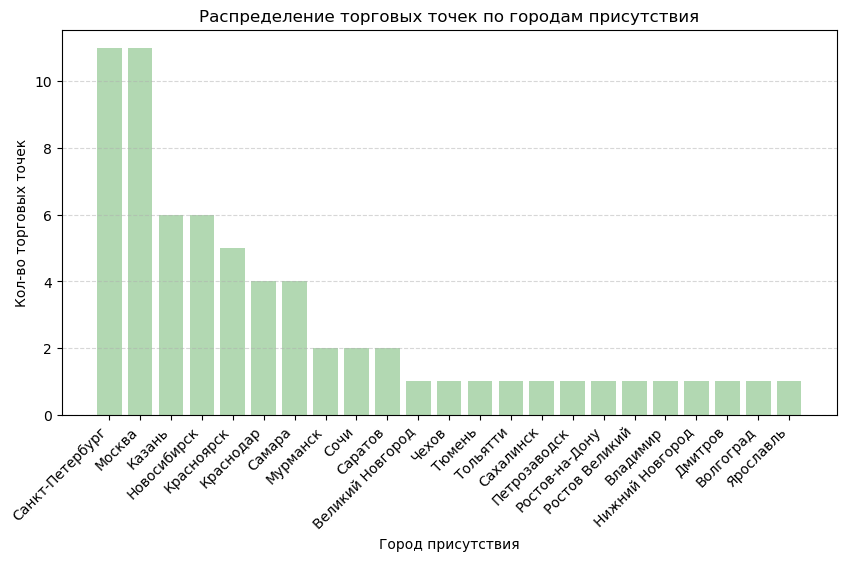

In [20]:

fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(tr_p_city['city'], tr_p_city['cnt_tr_p'], alpha = 0.3, color = 'green')
plt.title('Распределение торговых точек по городам присутствия')
plt.xlabel('Город присутствия')
plt.ylabel('Кол-во торговых точек')
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.show()

In [21]:
### Объединим таблицы

data_agg = data.groupby('id_client').agg(sum_paym = ('amt_payment', 'sum')).reset_index()
print(f'Кол-во уникальных id_client в исходном датафрейме data - {data['id_client'].nunique()}')
print()
print(f'Кол-во уникальных id_client в агрегированном датафрейме data_agg - {data_agg['id_client'].nunique()}')
print()
data_agg.head()

Кол-во уникальных id_client в исходном датафрейме data - 28383

Кол-во уникальных id_client в агрегированном датафрейме data_agg - 28383



,id_client,sum_paym
0,178561.0,3052.0
1,178562.0,2439.0
2,178563.0,768.0
3,178565.0,958.0
4,178566.0,5474.0


In [22]:

df = clients.merge(data_agg, on = 'id_client', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55605 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
 4   sum_paym          28383 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 MB


In [23]:
### Заполнили на "0" пустые ячейки в столбце sum_paym, чтобы обеспечить возможность работы с ними

df['sum_paym'] = df['sum_paym'].fillna(0)
df.isnull().sum()

id_client           0
dtime_ad            0
nflag_test          0
id_trading_point    0
sum_paym            0
dtype: int64

In [24]:

df = df.merge(regions, on = 'id_trading_point', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55605 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
 4   sum_paym          55605 non-null  float64       
 5   city              55605 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.5+ MB


In [25]:

df.head()

,id_client,dtime_ad,nflag_test,id_trading_point,sum_paym,city
0,178561,2022-06-03 02:47:49.183,0,453,3052.0,Санкт-Петербург
1,178562,2022-06-03 02:51:21.878,0,2652,2439.0,Москва
2,178563,2022-06-03 02:52:10.616,1,112,768.0,Санкт-Петербург
3,178564,2022-06-03 02:53:10.089,1,26,0.0,Ростов-на-Дону
4,178565,2022-06-03 02:55:13.525,1,739,958.0,Новосибирск


In [26]:
### Добавляем к таблице столбец flag_paym, отображающий наличие/отсутствие платежей по клиенту

df['flag_paym'] = np.where(df['sum_paym'] > 0, 1, 0)
df.head()

,id_client,dtime_ad,nflag_test,id_trading_point,sum_paym,city,flag_paym
0,178561,2022-06-03 02:47:49.183,0,453,3052.0,Санкт-Петербург,1
1,178562,2022-06-03 02:51:21.878,0,2652,2439.0,Москва,1
2,178563,2022-06-03 02:52:10.616,1,112,768.0,Санкт-Петербург,1
3,178564,2022-06-03 02:53:10.089,1,26,0.0,Ростов-на-Дону,0
4,178565,2022-06-03 02:55:13.525,1,739,958.0,Новосибирск,1


In [27]:
### Создаем функции для автоматизации вычислений

def ttest_calc(r1, r2, alpha = 0.05):
    c_tt, p_value_tt = ttest_ind(r1, r2)
    print(f'Значение критерия Стьюдента = {c_tt}.')
    print()
    if p_value_tt >= alpha:
        print(f'p value = {p_value_tt}. Принимаем H0, т.е. не обнаружено стат. значимой разницы между выборками.')
    else:
        print(f'p value = {p_value_tt}. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.')
    print()

In [28]:

def mann_whitney_func(r1, r2, alpha = 0.05):
    c_mw, p_value_mw = mannwhitneyu(r1, r2)
    print(f'Значение критерия Манна-Уитни = {c_mw}, отражает разницу в распределениях двух выборок.')
    print()
    if p_value_mw >= alpha:
        print(f'p value = {p_value_mw}. Н0 отклоняется, указывая на статистически значимые различия между двумя выборками.')
    else:
        print(f'p value = {p_value_mw}. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.')
    print()

In [29]:
### Создаем списки "пустых" торговых точек

df_tr_point_pays = df.groupby(['id_trading_point', 'nflag_test']).agg(sum_paym = ('sum_paym', 'sum'), cnt_clt = ('id_client', 'count')).reset_index()

tr_point_without_pay = df_tr_point_pays[df_tr_point_pays['sum_paym'] == 0]['id_trading_point'].unique().tolist()
print()
print(f'{tr_point_without_pay} - cписок торговых точек, в которых в тестовой или в контрольной группе не было заплачено ни одного рубля ни одним клиентом.')
print()

groups_per_point = df_tr_point_pays.groupby('id_trading_point')['nflag_test'].nunique()
one_group_tr_points = groups_per_point[groups_per_point == 1].index.tolist()
print(f'{one_group_tr_points} - cписок торговых точек, в которых клиенты только из одной группы, т.е. клиентов второй группы нет.')
print()

tr_point_without_group = df_tr_point_pays[((df_tr_point_pays['nflag_test'] == 0) & (df_tr_point_pays['cnt_clt'] == 0)) | ((df_tr_point_pays['nflag_test'] == 1) & (df_tr_point_pays['cnt_clt'] == 0))]['id_trading_point'].unique().tolist()
print(f'{tr_point_without_group} - проверка на торговые точки, в которых обозначились 2 группы, но одна из них пустая.')
print()


[1, 4, 7, 13, 23, 26, 46] - cписок торговых точек, в которых в тестовой или в контрольной группе не было заплачено ни одного рубля ни одним клиентом.

[228, 603, 739, 800, 810, 866, 1015, 1099] - cписок торговых точек, в которых клиенты только из одной группы, т.е. клиентов второй группы нет.

[] - проверка на торговые точки, в которых обозначились 2 группы, но одна из них пустая.



In [30]:
### Удаляем из датафрейма данные по торговым точкам с нулевыми платежами и нулевыми группами.

print(f'Кол-во торговых точек до удаления - {df['id_trading_point'].nunique()}')
print()
all_0_tr_points = tr_point_without_pay + one_group_tr_points + tr_point_without_group
df = df[~df['id_trading_point'].isin(all_0_tr_points)].dropna()
print(f'Кол-во торговых точек после удаления - {df['id_trading_point'].nunique()}')
print()

Кол-во торговых точек до удаления - 66

Кол-во торговых точек после удаления - 51



### Результаты А/В-тестов по общим выборкам (0 — контроль, 1 — тест). ###

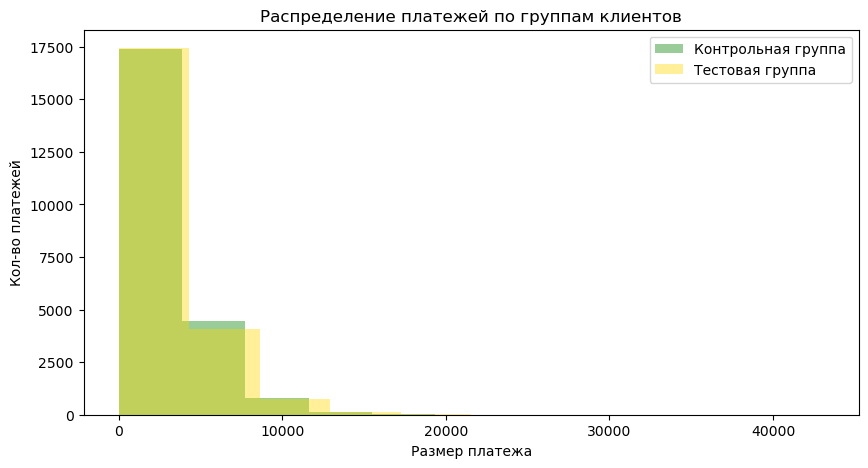

In [31]:

fig = plt.figure(figsize=(10, 5))

plt.hist(df[df['nflag_test'] == 0]['sum_paym'], color = 'g', label = 'Контрольная группа', alpha = 0.4)
plt.hist(df[df['nflag_test'] == 1]['sum_paym'], color = 'gold', label = 'Тестовая группа', alpha = 0.4)
plt.title('Распределение платежей по группам клиентов')
plt.xlabel('Размер платежа')
plt.ylabel('Кол-во платежей')
#plt.xlim(0, 20000)
plt.legend(loc = 'upper right')
plt.show()

In [32]:
### Посмотрим, каковы значения в каждой выборке

print()
print(f'Контрольная выборка - {df[df['nflag_test'] == 0]['sum_paym'].describe()}')
print()
print(f'Тестовая выборка - {df[df['nflag_test'] == 1]['sum_paym'].describe()}')
print()


Контрольная выборка - count    22873.000000
mean      2189.188432
std       2892.151567
min          0.000000
25%          0.000000
50%          0.000000
75%       3774.000000
max      38664.000000
Name: sum_paym, dtype: float64

Тестовая выборка - count    22445.000000
mean      2452.277345
std       3029.633084
min          0.000000
25%          0.000000
50%       1669.000000
75%       4060.000000
max      43083.000000
Name: sum_paym, dtype: float64



In [33]:
### сравниваем средние платежи

r1 = df[df['nflag_test'] == 0]['sum_paym']
r2 = df[df['nflag_test'] == 1]['sum_paym']

print()
print('Сравнение по средним платежам в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение по средним платежам в разбивке по группам


Значение критерия Стьюдента = -9.456798235171377.

p value = 3.3214645838934018e-21. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 243344369.0, отражает разницу в распределениях двух выборок.

p value = 3.008345273971901e-24. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



In [34]:
### сравниваем конверсию в платеж

r1 = df[df['nflag_test'] == 0]['flag_paym']
r2 = df[df['nflag_test'] == 1]['flag_paym']

print()
print('Сравнение средних конверсий в оплату в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение средних конверсий в оплату в разбивке по группам


Значение критерия Стьюдента = -9.282032730948323.

p value = 1.7338073027564523e-20. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 245519959.0, отражает разницу в распределениях двух выборок.

p value = 1.8043406994299902e-20. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



### Результаты А/В-тестов по выборкам (0 — контроль, 1 — тест) для Москвы. ###

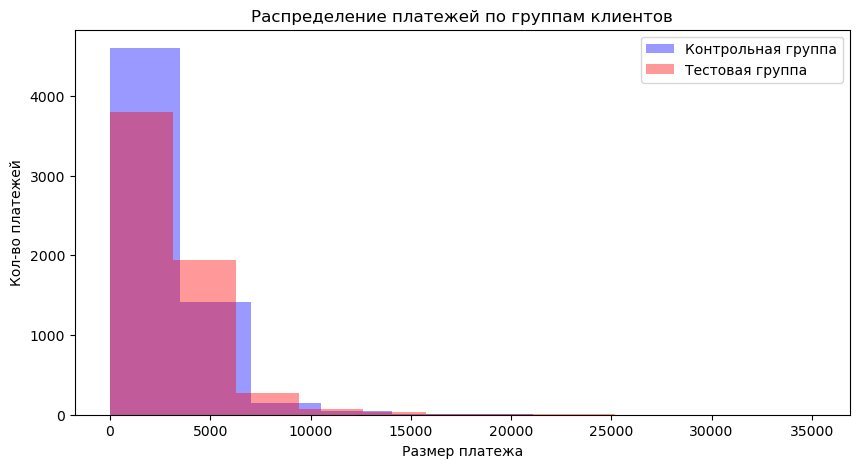

In [35]:

fig = plt.figure(figsize=(10, 5))

plt.hist(df[(df['nflag_test'] == 0) & (df['city'] == 'Москва')]['sum_paym'], color = 'blue', label = 'Контрольная группа', alpha = 0.4)
plt.hist(df[(df['nflag_test'] == 1) & (df['city'] == 'Москва')]['sum_paym'], color = 'red', label = 'Тестовая группа', alpha = 0.4)
plt.title('Распределение платежей по группам клиентов')
plt.xlabel('Размер платежа')
plt.ylabel('Кол-во платежей')
#plt.xlim(0, 20000)
plt.legend(loc = 'upper right')
plt.show()

In [36]:
### Посмотрим, каковы значения в каждой выборке

print()
print(f'Контрольная выборка - {df[(df['nflag_test'] == 0) & (df['city'] == 'Москва')]['sum_paym'].describe()}')
print()
print(f'Тестовая выборка - {df[(df['nflag_test'] == 1) & (df['city'] == 'Москва')]['sum_paym'].describe()}')
print()


Контрольная выборка - count     6224.000000
mean      1986.180591
std       2653.664282
min          0.000000
25%          0.000000
50%          0.000000
75%       3581.500000
max      35136.000000
Name: sum_paym, dtype: float64

Тестовая выборка - count     6134.000000
mean      2367.959081
std       2872.144787
min          0.000000
25%          0.000000
50%       1725.500000
75%       4047.000000
max      31488.000000
Name: sum_paym, dtype: float64



In [37]:
### сравниваем средние платежи

r1 = df[(df['nflag_test'] == 0) & (df['city'] == 'Москва')]['sum_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] == 'Москва')]['sum_paym']

print()
print('Сравнение по средним платежам в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение по средним платежам в разбивке по группам


Значение критерия Стьюдента = -7.676511027843395.

p value = 1.757549439555765e-14. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 17582441.5, отражает разницу в распределениях двух выборок.

p value = 7.010591402203484e-16. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



In [38]:
### сравниваем конверсию в платеж

r1 = df[(df['nflag_test'] == 0) & (df['city'] == 'Москва')]['flag_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] == 'Москва')]['flag_paym']

print()
print('Сравнение средних конверсий в оплату в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение средних конверсий в оплату в разбивке по группам


Значение критерия Стьюдента = -6.190312288026297.

p value = 6.194689260032549e-10. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 18028079.0, отражает разницу в распределениях двух выборок.

p value = 6.370381156613038e-10. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



### Результаты А/В-тестов по выборкам (0 — контроль, 1 — тест) для Санкт-Петербурга. ###

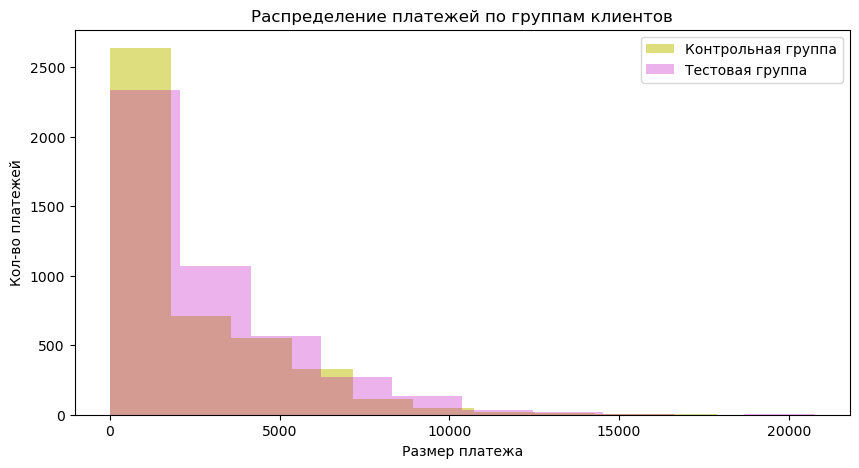

In [39]:

fig = plt.figure(figsize=(10, 5))

plt.hist(df[(df['nflag_test'] == 0) & (df['city'] == 'Санкт-Петербург')]['sum_paym'], color = 'y', label = 'Контрольная группа', alpha = 0.5)
plt.hist(df[(df['nflag_test'] == 1) & (df['city'] == 'Санкт-Петербург')]['sum_paym'], color = 'm', label = 'Тестовая группа', alpha = 0.3)
plt.title('Распределение платежей по группам клиентов')
plt.xlabel('Размер платежа')
plt.ylabel('Кол-во платежей')
#plt.xlim(0, 20000)
plt.legend(loc = 'upper right')
plt.show()

In [40]:
### Посмотрим, каковы значения в каждой выборке

print()
print(f'Контрольная выборка - {df[(df['nflag_test'] == 0) & (df['city'] == 'Санкт-Петербург')]['sum_paym'].describe()}')
print()
print(f'Тестовая выборка - {df[(df['nflag_test'] == 1) & (df['city'] == 'Санкт-Петербург')]['sum_paym'].describe()}')
print()


Контрольная выборка - count     4434.000000
mean      1913.558638
std       2642.613816
min          0.000000
25%          0.000000
50%          0.000000
75%       3538.750000
max      17876.000000
Name: sum_paym, dtype: float64

Тестовая выборка - count     4445.000000
mean      2427.462542
std       2880.109268
min          0.000000
25%          0.000000
50%       1702.000000
75%       4024.000000
max      20760.000000
Name: sum_paym, dtype: float64



In [41]:
### сравниваем средние платежи

r1 = df[(df['nflag_test'] == 0) & (df['city'] == 'Санкт-Петербург')]['sum_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] == 'Санкт-Петербург')]['sum_paym']

print()
print('Сравнение по средним платежам в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение по средним платежам в разбивке по группам


Значение критерия Стьюдента = -8.759635784179547.

p value = 2.3198088937974163e-18. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 8809444.5, отражает разницу в распределениях двух выборок.

p value = 2.0392184217953754e-20. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



In [42]:
### сравниваем конверсию в платеж

r1 = df[(df['nflag_test'] == 0) & (df['city'] == 'Санкт-Петербург')]['flag_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] == 'Санкт-Петербург')]['flag_paym']

print()
print('Сравнение средних конверсий в оплату в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение средних конверсий в оплату в разбивке по группам


Значение критерия Стьюдента = -9.352468686561785.

p value = 1.065825659919673e-20. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 8881151.0, отражает разницу в распределениях двух выборок.

p value = 1.3118606823466691e-20. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



### Результаты А/В-тестов по выборкам (0 — контроль, 1 — тест) для других городов. ###

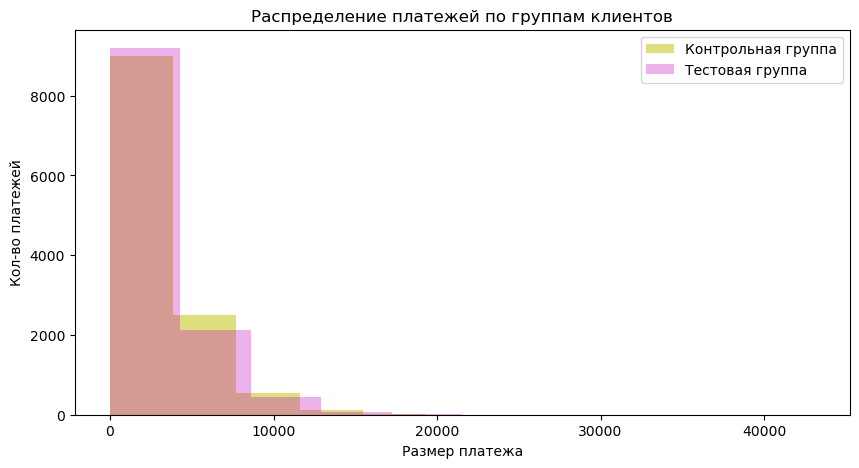

In [43]:

fig = plt.figure(figsize=(10, 5))

plt.hist(df[(df['nflag_test'] == 0) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym'], color = 'y', label = 'Контрольная группа', alpha = 0.5)
plt.hist(df[(df['nflag_test'] == 1) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym'], color = 'm', label = 'Тестовая группа', alpha = 0.3)
plt.title('Распределение платежей по группам клиентов')
plt.xlabel('Размер платежа')
plt.ylabel('Кол-во платежей')
#plt.xlim(0, 20000)
plt.legend(loc = 'upper right')
plt.show()

In [44]:
### Посмотрим, каковы значения в каждой выборке

print()
print(f'Контрольная выборка - {df[(df['nflag_test'] == 0) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym'].describe()}')
print()
print(f'Тестовая выборка - {df[(df['nflag_test'] == 1) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym'].describe()}')
print()


Контрольная выборка - count    12215.00000
mean      2392.68113
std       3074.25693
min          0.00000
25%          0.00000
50%       1265.00000
75%       3958.00000
max      38664.00000
Name: sum_paym, dtype: float64

Тестовая выборка - count    11866.000000
mean      2505.160374
std       3159.893205
min          0.000000
25%          0.000000
50%       1622.500000
75%       4084.000000
max      43083.000000
Name: sum_paym, dtype: float64



In [45]:
### сравниваем средние платежи

r1 = df[(df['nflag_test'] == 0) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['sum_paym']

print()
print('Сравнение по средним платежам в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение по средним платежам в разбивке по группам


Значение критерия Стьюдента = -2.799833948375294.

p value = 0.005116960359573606. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 71035036.5, отражает разницу в распределениях двух выборок.

p value = 0.0049446987638856145. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



In [46]:
### сравниваем конверсию в платеж

r1 = df[(df['nflag_test'] == 0) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['flag_paym']
r2 = df[(df['nflag_test'] == 1) & (df['city'] != 'Санкт-Петербург') & (df['city'] != 'Москва')]['flag_paym']

print()
print('Сравнение средних конверсий в оплату в разбивке по группам')
print()
print()
ttest_calc(r1, r2, alpha = 0.05)
print()
mann_whitney_func(r1, r2, alpha = 0.05)


Сравнение средних конверсий в оплату в разбивке по группам


Значение критерия Стьюдента = -2.6871624139823846.

p value = 0.007211139569659334. Принимаем H1, т.е. обнаружена стат. значимая разница между выборками.


Значение критерия Манна-Уитни = 71219383.0, отражает разницу в распределениях двух выборок.

p value = 0.0072137043853313. Нет достаточных оснований отклонять Н0 и нельзя утверждать, что распределения различаются.



### Создадим датафрейм для дашборда ###

In [47]:

listt = []

alpha = 0.05
cnt_df_clients = df['id_client'].count()

for trad_p in df['id_trading_point'].unique():
    df_city_tradp = df[df['id_trading_point'] == trad_p]

    city = df_city_tradp['city'].iloc[0]
    
    count_test = len(df_city_tradp[df_city_tradp['nflag_test']==1])
    count_control = len(df_city_tradp[df_city_tradp['nflag_test']==0])
        
    count_all = count_test + count_control
        
    percent_count = count_all / cnt_df_clients * 100

    sample1 = df_city_tradp[df_city_tradp['nflag_test'] == 1]['sum_paym']
    sample0 = df_city_tradp[df_city_tradp['nflag_test'] == 0]['sum_paym']
        
    avg_payment_test = sample1.mean()
    avg_payment_control = sample0.mean()

    diff = avg_payment_test - avg_payment_control 

    sigma_test = np.std(sample1, ddof = 1)
    sigma_control = np.std(sample0, ddof = 1)

    c_tt, p_value_tt = ttest_ind(sample1, sample0)

    result = np.where((p_value_tt < alpha) & (diff > 0),'positive', np.where((p_value_tt < alpha) & (diff < 0), 'negative', 'neutral'))

    listt.append({'city':city, 'id_trading_point':trad_p, 'count_test':count_test, 'count_control':count_control, 'count_all':count_all, 
                  'percent_count':percent_count, 'avg_payment_test':avg_payment_test, 'avg_payment_control':avg_payment_control, 'diff':diff, 
                  'sigma_test':sigma_test, 'sigma_control':sigma_control, 'ttest':c_tt, 'pvalue_ttest':p_value_tt, 'exp_flag':result})

to_excel = pd.DataFrame(listt)
to_excel.head()

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,exp_flag
0,Санкт-Петербург,453,1066,1049,2115,4.667020,2501.966229,1889.923737,612.042492,2993.442540,2648.659303,4.976910,6.983207e-07,positive
1,Москва,2652,2273,2370,4643,10.245377,2506.616806,1972.847679,533.769127,2842.182948,2565.878242,6.722230,2.005922e-11,positive
2,Санкт-Петербург,112,652,683,1335,2.945849,2488.115031,2218.636896,269.478135,2778.179183,2780.790660,1.770712,7.683710e-02,neutral
3,Москва,3786,237,278,515,1.136414,2613.683544,2688.230216,-74.546672,2712.235859,3292.937641,-0.277399,7.815857e-01,neutral
4,Санкт-Петербург,117,625,587,1212,2.674434,2582.297600,2050.691652,531.605948,2835.004503,2595.737792,3.398196,7.003817e-04,positive


In [48]:

to_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 51 non-null     object 
 1   id_trading_point     51 non-null     int64  
 2   count_test           51 non-null     int64  
 3   count_control        51 non-null     int64  
 4   count_all            51 non-null     int64  
 5   percent_count        51 non-null     float64
 6   avg_payment_test     51 non-null     float64
 7   avg_payment_control  51 non-null     float64
 8   diff                 51 non-null     float64
 9   sigma_test           51 non-null     float64
 10  sigma_control        51 non-null     float64
 11  ttest                51 non-null     float64
 12  pvalue_ttest         51 non-null     float64
 13  exp_flag             51 non-null     object 
dtypes: float64(8), int64(4), object(2)
memory usage: 5.7+ KB


In [49]:

#to_excel.to_excel('Для дашборда.xlsx', index = True)

In [50]:

#categories = ['positive', 'negative', 'neutral']

#with pd.ExcelWriter('Для дашборда.xlsx') as writer:
#    for category in categories:
#        df_filtered = to_excel[to_excel['exp_flag'] == category]
        
        # Используем значение категории как название листа
        # Ограничиваем длину названия листа до 31 символа (ограничение Excel)
#        sheet_name = str(category)[:31]
        
#        df_filtered.to_excel(writer, sheet_name = sheet_name, index=False)